<a href="https://colab.research.google.com/github/nirkoren1/Chord_Transformer/blob/master/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pickle5
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import tensorflow as tf
import pickle5
import pickle
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, LayerNormalization, Dropout, Embedding, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from matplotlib import style
import tensorflow_datasets as tfds
import tensorflow_text

In [5]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']
train_examples

<PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [6]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

'./ted_hrlr_translate_pt_en_converter.zip'

In [7]:
tokenizers = tf.saved_model.load(model_name)

In [8]:
max_sample_size = 100


def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)      # Output is ragged.
    pt = pt[:, :max_sample_size]    # Trim to MAX_TOKENS.
    pt = pt.to_tensor()  # Convert to 0-padded dense Tensor

    en = tokenizers.en.tokenize(en)
    en = en[:, :(max_sample_size + 1)]
    en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

    return (pt, en_inputs), en_labels
BUFFER_SIZE = 20000
BATCH_SIZE = 8


def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))


# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [9]:
def pad_to_max_size(batch, max_size=max_sample_size, padding_value=0):
  batch = tf.pad(batch, [[0, 0], [0, max_size - batch.shape[-1]]], 'CONSTANT', constant_values=padding_value)
  return batch

for (pt, en) , en_val in train_batches:
  print(pt.shape)
  en = pad_to_max_size(en)
  en_val = pad_to_max_size(en_val)
  print(en.shape)
  print(en_val.shape)
  break

(8, 75)
(8, 100)
(8, 100)


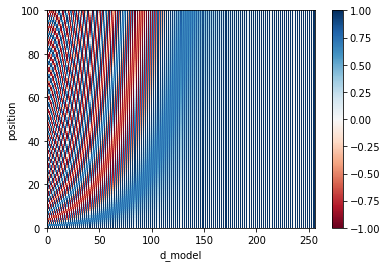

In [10]:
d_model = 256
def position_encoding(pos, i, embedding_size):
    if i % 2 == 0:
        return np.sin(pos / (10000 ** (2 * (i // 2) / embedding_size)))
    return np.cos(pos / (10000 ** (2 * (i // 2) / embedding_size)))
positional_matrix = tf.convert_to_tensor([[position_encoding(i, j, d_model) for j in range(d_model)] for i in range(max_sample_size)], dtype=tf.float32)
plt.pcolormesh(positional_matrix, cmap='RdBu')
plt.ylabel('position')
plt.xlabel('d_model')
plt.colorbar()
plt.show()

In [11]:
def add_positional_embedding(batch):
  postion_embedding_sliced = positional_matrix[:batch.shape[-2], :batch.shape[-1]]
  out = []
  for sample in batch:
    out.append(tf.add(sample, postion_embedding_sliced))
  return tf.convert_to_tensor(out)
example = [[0, 0.2, 0, 0],
           [0, 0, 0, 0]]
example = tf.convert_to_tensor([example], dtype=tf.float32)
add_positional_embedding(example)

<tf.Tensor: shape=(1, 2, 4), dtype=float32, numpy=
array([[[0.        , 1.2       , 0.        , 1.        ],
        [0.84147096, 0.5403023 , 0.8019618 , 0.59737533]]], dtype=float32)>

In [12]:
largest_mask = [[[0. if i >= j else 1 for j in range(max_sample_size)] for i in range(max_sample_size)] for k in range(BATCH_SIZE)]
largest_mask = tf.convert_to_tensor(largest_mask, dtype=tf.float32)
def look_ahead_mask(batch):
  return largest_mask[:, :batch.shape[1]:, :batch.shape[1]:]

def padding_mask(keys_tekenized):
    mask = tf.cast(tf.math.equal(keys_tekenized, 0), tf.float32)
    return mask[:, tf.newaxis, :]

def padding_and_look_ahead_mask(batch):
  return tf.maximum(padding_mask(batch), look_ahead_mask(batch))

for (pt, en), en_val in train_batches:
  print(en)
  ex = tf.convert_to_tensor([[[np.random.random() for _ in range(en.shape[-1])] for _ in range(pt.shape[-1])] for _ in range(8)], dtype=tf.float32)
  mask = padding_mask(en)
  ex += (-1e9 * mask)
  print(ex)
  ex2 = tf.convert_to_tensor([[[np.random.random() for _ in range(en.shape[-1])] for _ in range(en.shape[-1])] for _ in range(8)], dtype=tf.float32)
  ex2 += (-1e9 * padding_and_look_ahead_mask(en))
  print(ex2)
  break

tf.Tensor(
[[   2   85   81  195   13  250  213   13 4174 2504 3305  651 1667   71
  2758 2084   15    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   2   10  189   11    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   2   72   71  487 1238   89   37  123  630 6716   15    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   2   72   90   95  576   30    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0

In [13]:
def attention_head(q, k, v, mask):
  dk = q.shape[-1]
  QK = tf.linalg.matmul(q, k, transpose_b=True)
  QK = tf.scalar_mul(1 / np.sqrt(dk), QK)
  QK += mask * -1e9
  QK = tf.nn.softmax(QK, axis=-1)
  QKV = tf.linalg.matmul(QK, v)
  return QKV

In [14]:
class MultiHeadAttention(keras.layers.Layer):
  def __init__(self, d_model, h: int, dropout_rate=0.1):
    super(MultiHeadAttention, self).__init__()
    self.h = h
    self.d_model = d_model
    self.dk = d_model / h
    self.normalize = LayerNormalization(axis=-1, center=True, scale=True, epsilon=0.0001)
    self.fc = Dense(d_model)
    self.dropout = Dropout(dropout_rate)
    self.value_weights = [Dense(self.dk) for _ in range(h)]
    self.query_weights = [Dense(self.dk) for _ in range(h)]
    self.key_weights = [Dense(self.dk) for _ in range(h)]

  def call(self, q, k, v, mask, training=False):
    query = tf.split(q, self.h, axis=-1)
    key = tf.split(k, self.h, axis=-1)
    value = tf.split(v, self.h, axis=-1)
    query_processed = [self.query_weights[i](query[i]) for i in range(self.h)]
    key_processed = [self.key_weights[i](key[i]) for i in range(self.h)]
    value_processed = [self.value_weights[i](value[i]) for i in range(self.h)]
    attentions = [attention_head(query_processed[i], key_processed[i], value_processed[i], mask) for i in range(self.h)]
    result = tf.concat(attentions, -1)
    result = self.fc(result)
    if training:
      result = self.dropout(result)
    result = tf.add(result, q)
    result = self.normalize(result)
    return result

In [15]:
class FeedForwardBlock(keras.layers.Layer):
  def __init__(self, d_model, hidden_layer_size, dropout_rate=0.1):
    super(FeedForwardBlock, self).__init__()
    self.fc1 = Dense(hidden_layer_size, activation="relu")
    self.fc2 = Dense(d_model)
    self.normalize = LayerNormalization(axis=-1, center=True, scale=True, epsilon=0.0001)
    self.dropout = Dropout(dropout_rate)

  def call(self, input_tensor, training=False):
    result = self.fc1(input_tensor)
    result = self.fc2(result)
    if training:
      result = self.dropout(result)
    result = tf.add(result, input_tensor)
    result = self.normalize(result)
    return result

In [16]:
class Encoder(keras.layers.Layer):
  def __init__(self, d_model, h, encoder_dict_size, N=6):
    super().__init__()
    self.N = N
    self.d_model = d_model
    self.h = h
    self.embedding = Embedding(encoder_dict_size, d_model, mask_zero=True)
    self.mah = [MultiHeadAttention(self.d_model, self.h) for _ in range(N)]
    self.feed_forwards = [FeedForwardBlock(d_model, d_model * 4) for _ in range(N)]

  def call(self, encoder_input, training=False):
    mask = padding_mask(encoder_input)
    result = self.embedding(encoder_input)
    result *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    result = add_positional_embedding(result)
    for i in range(self.N):
      result = self.mah[i](result, result, result, mask, training)
      result = self.feed_forwards[i](result, training)
    return result

In [17]:
class Decoder(keras.layers.Layer):
  def __init__(self, d_model, h, decoder_dict_size, N=6):
    super().__init__()
    self.N = N
    self.d_model = d_model
    self.h = h
    self.embedding = Embedding(decoder_dict_size, d_model, mask_zero=True)
    self.mah_first = [MultiHeadAttention(self.d_model, self.h) for _ in range(N)]
    self.mah_second = [MultiHeadAttention(self.d_model, self.h) for _ in range(N)]
    self.feed_forwards = [FeedForwardBlock(d_model, d_model * 4) for _ in range(N)]

  def call(self, decoder_input, encoder_out, encoder_mask, training=False):
    decoder_mask = padding_and_look_ahead_mask(decoder_input)
    result = self.embedding(decoder_input)
    result *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    result = add_positional_embedding(result)
    for i in range(self.N):
      result = self.mah_first[i](result, result, result, decoder_mask, training)
      result = self.mah_second[i](result, encoder_out, encoder_out, encoder_mask, training)
      result = self.feed_forwards[i](result, training)
    return result

In [18]:
class Transformer(keras.Model):
  def __init__(self, d_model, h, encoder_dict_size, decoder_dict_size):
        super().__init__()
        self.d_model = d_model
        self.encoder = Encoder(d_model, h, encoder_dict_size)
        self.decoder = Decoder(d_model, h, decoder_dict_size)
        self.flat = Flatten()
        self.final_layer = Dense(decoder_dict_size)

        self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

        self.accs = []
        self.losses_lst = []

  def call(self, encoder_input_tokenized, decoder_input_tokenized, training=False):
      encoder_output = self.encoder(encoder_input_tokenized, training)
      decoder_output = self.decoder(decoder_input_tokenized, encoder_output, padding_mask(encoder_input_tokenized), training)
      # result = self.flat(decoder_output)
      result = self.final_layer(decoder_output)
      return result

  def learn(self, encoder_input, decoder_input, true_output, print_acc):
        with tf.GradientTape(persistent=True) as tape:
            guess = self(encoder_input, decoder_input, training=True)
            loss = self.loss_function(true_output, guess)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.losses_lst.append(loss.numpy())
        self.accs.append(self.accuracy_function(true_output, guess).numpy())

  def loss_function(self, real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = self.loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

  def accuracy_function(self, real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

  def get_acc_moving_avg(self, window_size=50):
    if len(self.accs) < window_size:
      return sum(self.accs) / len(self.accs)
    return sum(self.accs[-window_size:]) / window_size

  def get_loss_moving_avg(self, window_size=50):
    if len(self.losses_lst) < window_size:
      return sum(self.losses_lst) / len(self.losses_lst)
    return sum(self.losses_lst[-window_size:]) / window_size

transformer_ex = Transformer(d_model, 8, tokenizers.pt.get_vocab_size(), tokenizers.en.get_vocab_size())
i = 0
for (pt, en), en_val in train_batches:
  i += 1
  en = pad_to_max_size(en)
  print(transformer_ex(pt, en))
  if i == 2:
    break

tf.Tensor(
[[[ 0.15964408  0.18907712  0.49732405 ...  0.1300615  -0.39625865
    0.29145682]
  [ 0.16014405  0.20575017  0.49606556 ...  0.13447057 -0.4006994
    0.28047284]
  [ 0.17685089  0.20450991  0.49040714 ...  0.1366129  -0.3974294
    0.27762145]
  ...
  [ 0.16228396  0.22284108  0.4739986  ...  0.15889518 -0.41094655
    0.24529114]
  [ 0.16152656  0.22403373  0.47195056 ...  0.15988092 -0.41083547
    0.24593547]
  [ 0.16110611  0.2237476   0.47021922 ...  0.1605464  -0.40944073
    0.24812981]]

 [[ 0.08524548  0.22639348  0.47511637 ...  0.3189313  -0.28601623
    0.20891605]
  [ 0.09469771  0.23978144  0.46362436 ...  0.3050195  -0.28446364
    0.21913007]
  [ 0.09501659  0.24216974  0.46898967 ...  0.30866334 -0.28389382
    0.21299215]
  ...
  [ 0.10017024  0.26533127  0.4531354  ...  0.30840623 -0.30336803
    0.21559389]
  [ 0.09859148  0.26567733  0.45100704 ...  0.30905148 -0.30437645
    0.21548875]
  [ 0.09688811  0.26516497  0.44902578 ...  0.31045446 -0.303736

In [19]:
transformer_ex.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  5694208   
                                                                 
 decoder (Decoder)           multiple                  6050816   
                                                                 
 flatten (Flatten)           multiple                  0 (unused)
                                                                 
 dense_474 (Dense)           multiple                  1801570   
                                                                 
Total params: 13,546,594
Trainable params: 13,546,594
Non-trainable params: 0
_________________________________________________________________


In [20]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [21]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
transformer_ex.compile(optimizer=optimizer)

In [22]:
def main_loop(epochs):
  epoch = 0
  best_acc = 0
  for (pt, en), en_val in train_batches:
    if epoch == epochs:
      break
    if en.shape[-1] > 99:
      continue
    en = pad_to_max_size(en)
    en_val = pad_to_max_size(en_val)
    transformer_ex.learn(pt, en, en_val, True)
    print(f"{epoch} loss: {transformer_ex.get_loss_moving_avg()} acc: {transformer_ex.get_acc_moving_avg()}")
    # animate.update(transformer.get_loss_moving_avg(), "loss_scores", 0)
    # animate.update(transformer.get_acc_moving_avg(), "acc_scores", 1)
    if epoch == 9:
        exit(0)
    if transformer_ex.get_acc_moving_avg() > best_acc and epoch % 10 == 0:
        best_acc = transformer_ex.get_acc_moving_avg()
        print(f"saving model with acc of {best_acc}")
        transformer_ex.save_weights("weights")
    epoch += 1

In [ ]:
main_loop(100_000)

0 loss: 8.851877212524414 acc: 0.0
1 loss: 8.876928806304932 acc: 0.0
2 loss: 8.885518391927084 acc: 0.0
3 loss: 8.878791332244873 acc: 0.0
4 loss: 8.880947303771972 acc: 0.0
5 loss: 8.878503004709879 acc: 0.0
6 loss: 8.878143991742816 acc: 0.0
7 loss: 8.874233961105347 acc: 0.0
8 loss: 8.875199847751194 acc: 0.0
9 loss: 8.880375385284424 acc: 0.0
10 loss: 8.881272315979004 acc: 0.0
11 loss: 8.882164239883423 acc: 0.0
12 loss: 8.879814368027906 acc: 0.0
13 loss: 8.879585197993688 acc: 0.0
14 loss: 8.878856786092122 acc: 0.0
15 loss: 8.877076625823975 acc: 0.0
16 loss: 8.876099418191348 acc: 0.0
17 loss: 8.87512657377455 acc: 0.0
18 loss: 8.875316419099507 acc: 0.0
19 loss: 8.871583127975464 acc: 0.0
20 loss: 8.86679372333345 acc: 0.0
21 loss: 8.86250352859497 acc: 0.0
22 loss: 8.860871480858844 acc: 0.0
23 loss: 8.85684104760488 acc: 0.0
24 loss: 8.852139472961426 acc: 0.0
25 loss: 8.849775351010836 acc: 0.0
26 loss: 8.846123730694806 acc: 0.0
27 loss: 8.841299942561559 acc: 0.0
28 los